# Introduction

In this notebook I will create a simple probability for each course to be passed. My method and assumptions will be discussed as I work through the process.

The official request is as follows:

Using Python, predict how likely a course is to be passed (note: we are not evaluating the accuracy of your model, but are looking at the quality of your code). Please comment liberally in your code so we can see your thought process. 

## Import, Functions, and Connections

In [1]:
import pandas as pd
import sqlite3
import numpy as np

In [2]:
%matplotlib inline

In [3]:
working_dir = '/Users/jmbeck/Desktop/guild_eval'

In [4]:
conn = sqlite3.connect(working_dir + '/db/eval_db.sqlite')

## Data Load

I will be leveraging my SQLite database for the information in this part of the task.

In [5]:
course_data_query = '''
SELECT A.*
 , B.[Sf Contact ID]
FROM COURSE_DETAILS A
LEFT JOIN CONTACT_DETAILS B
ON A.[Sf Course C ID] = B.[Sf Course C ID]
'''

In [6]:
course_data = pd.read_sql(course_data_query, conn)

Let's now take an initial look at how much data we have to work with.

In [7]:
course_data.head()

,Sf Course C ID,Sf Course C Name,Sf Course C Course Start Date C Date,Sf Course C Course End Date C Date,Sf Course C Final Grade C,Sf Contact ID
0,a1C36000009t3tGEAQ,High School Completion Program,None,None,None,0033600001d8VYSAA2
1,a1C36000009eJkMEAU,Management Training Program - 16 Week,None,None,None,0033600001cWhGvAAK
2,a1C36000009u2k9EAA,High School Completion Program,None,None,None,0033600001eviAGAAY
3,a1C36000009fIoUEAU,High School Completion Program,None,None,None,0033600001e0cVpAAI
4,a1C36000005okzZEAQ,Management Training Program - 16 Week,None,None,None,0033600001E7j5fAAB


The only information stored in this data set are the course name and id, start and end date, and the final grade.  I've also included the contact id for the student completing each instance of a course.

This does not leave us any real information to model with using machine learning methods, unless we bring outside information in.  I will probably need to rely on statistical methods and the observed outcomes.

** Missingness**

In [8]:
100*(course_data.isnull().sum()/course_data.shape[0])

Sf Course C ID                           0.000000
Sf Course C Name                         0.000000
Sf Course C Course Start Date C Date     0.118859
Sf Course C Course End Date C Date       0.435816
Sf Course C Final Grade C               63.866878
Sf Contact ID                            0.000000
dtype: float64

The end date for courses is missing in many cases, and final grades are frequently missing.  Since there is no additional information, I have to assume that data can not be used for modeling, as we do not have outcomes for those course enrollments.

In [9]:
# Split the data set based on the presence of a final grade.
null_data = course_data[course_data['Sf Course C Final Grade C'].isnull()].copy()
usable_data = course_data[-course_data['Sf Course C Final Grade C'].isnull()].copy()

In [10]:
usable_data.shape

(2736, 6)

Let's take a quick look at the course grades to ensure they look like what we saw in our successful outcomes query from the technical queries portion of this exercise.

In [11]:
usable_data['Sf Course C Final Grade C'].value_counts()

A         664
Passed    446
B         278
F         248
A-        215
C         177
Failed    139
B+        129
W          98
B-         77
C+         77
WA         48
D          44
FA         23
C-         18
FW         17
WP         12
D+          9
D-          6
IF          6
S           2
SP          1
U           1
I           1
Name: Sf Course C Final Grade C, dtype: int64

Of the instances where a student has a grade in a course, the majority of those marks are passing. Unfortuntely we had to throw away the majority of our data, since no course outcomes were present.  

### Defining Successful Outcomes

The request of this task is to determine the probability that a course will be passed. Let's look at the outcomes for each course in the provided data set.

In [12]:
# This logic was used in the final query to define successful marks.  Please refer to 01_technical_project_queries
# Question 3 for links to justify my choices. 
successful_outcomes = ['A','A-','B+','B','B-','C+','C','C-','D+','D','D-','Passed','S']

Determine whether the course was passed in each instance of a course being taken by checking if the final grade in each row of the dataframe is present in the successful_outcomes list. 

In [13]:
usable_data['passing_grade'] = usable_data['Sf Course C Final Grade C'].apply(lambda x: x in successful_outcomes)

In [14]:
usable_data.head()

,Sf Course C ID,Sf Course C Name,Sf Course C Course Start Date C Date,Sf Course C Course End Date C Date,Sf Course C Final Grade C,Sf Contact ID,passing_grade
585,a1C36000008rUXCEA2,Intro to Critical Thinking,2018-10-29 00:00:00,2018-12-17 00:00:00,FA,0033600001KrOCYAA3,False
586,a1C36000008rUXdEAM,Personal Wellness,2018-10-29 00:00:00,2018-12-17 00:00:00,FA,0033600001KrOCYAA3,False
587,a1C36000007g8EtEAI,Personal Wellness,2018-10-29 00:00:00,2018-12-17 00:00:00,FA,0033600001KrOCYAA3,False
588,a1C36000007g8EhEAI,Nurse as Caregiver,2018-10-29 00:00:00,2018-12-17 00:00:00,C+,0033600001LGqKoAAL,True
589,a1C36000007g8EaEAI,Nurse as Caregiver,2018-10-29 00:00:00,2018-12-17 00:00:00,A,0033600001BD3KJAA1,True


In [15]:
usable_data.passing_grade.value_counts()

True     2142
False     594
Name: passing_grade, dtype: int64

As we saw in the grading distribution earlier, most instances of a course being taken result in a passing mark. 

# Predicting Probability of Passing a Course

The assignment request was to predict the probability of passing a course. Unfortunately, we do not have additional data that could be used to discriminate these courses in a machine learning model, which limits our available methods to more statistical methods based on the observed outcomes across students.  

I will model the potential probability of passing a course using two methods:
  1. The observed probability _any_ students passing _any_ course in the data set.
  2. The estimated probability of _any_ student passing _a specific_ course in the data set. 

## Simplest Prediction

A simple way to see a baseline probability of a course being passed is the fraction of times it was observed to be passed in the data set. Since we have a boolean for whether each instance was successful already in the data set, we can aggregate on 'Sf Course C Name', and calculate a mean of passing_to get the fraction of times a course was passed.

In [16]:
usable_data.passing_grade.mean()

0.7828947368421053

Across all courses, the observed fraction of courses passed is 78%.

## Probability of Passing a Specific Course

In this section I will look into how many times each course has been passed, and use that to estimate a probability of passing the course for any student.  

First let's take a look at a distribution of how many times each course has been taken in the data set.

Distribution of Course Completions


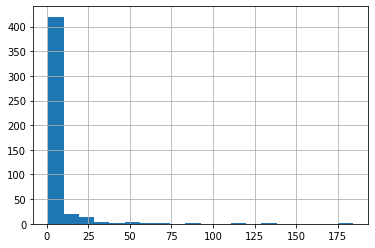

In [17]:
print('Distribution of Course Completions')
_ = usable_data.groupby('Sf Course C Name').size().hist(bins=20)

Whew, the majority of courses in this data set have been taken very few times. That means I have my work cut out for me getting a reasonable probablity estimate for passing an individual course. Estimating uncertianty is going to be critical. 

Count of Courses by Fraction of Successful Outcomes


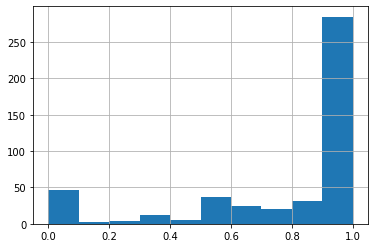

In [18]:
print('Count of Courses by Fraction of Successful Outcomes')
_ = usable_data.groupby('Sf Course C Name').passing_grade.mean().hist()

Most courses have a very high percentage of students passing them. Of course the spikes at 1 and 0 are largely due to a single student taking the course and either passing or failing. We know from flipping a coin that flipping a coin once and getting a single outcome doesn't mean there's actually a 100% chance of that outcome, so we will need to do some estimation.  

In [19]:
pred_data = usable_data.groupby('Sf Course C Name').agg({'passing_grade': [np.mean, sum, len]})

In [20]:
pred_data.columns = ['calc_outcome','success','total']

In [21]:
pred_data.head(10)

,calc_outcome,success,total
Sf Course C Name,,,
21st Century Global Issues,1.000000,2.0,2
Abnormal Psychology,1.000000,4.0,4
Academic Foundations,0.750000,3.0,4
Accounting 1,0.500000,1.0,2
Accounting I,0.000000,0.0,1
Accounting and Finance for Healthcare Managers,0.500000,2.0,4
Accounting for Performance Man,1.000000,1.0,1
Advanced Accounting Problems,1.000000,1.0,1
Advanced Networking Using Java,1.000000,1.0,1


The course outcomes here appear to be the only 'features' we have to work with to get individual course level estimates. 

### Wilson Score Interval

I am going to attempt to use the Wilson score interval here to use bernoulli trial outcomes for estimating the actual probability and confidence intervals. Given that we have so many courses that have only been taken once or twice, there are calculated outcomes that are 100% pass or 100% fail, and the Wilson score interval reportedly provides good behavior in these sitautions (see link below). There are some assumptions here that aren't technically met, namely that the probability of outcomes in each trial is not constant (different students should have different likelihoods of passing a course.)  However, with the lack of data across most classes, there isn't much else we can do.

https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

My function will return a tuple containing the corrected probability estimate, which I will call wilson_p, and the +/- correction for the confidence intervals.

In [22]:
def wilson_score_interval(n_trials=None, n_success=None, z=1.96):
    '''
    Function to estimate the corrected probability and confidence interval range using bernoilli trial outcomes. 
    
    input: n_trials: (int) The number of times a course was taken
    input: n_success: (int) The number of times a passing grade was achieved for the course
    input: z: (float) The Z-score for the confidence interval range. 
    
    returns: (p, conf) (tuple, floats)  The corrected probability estimate and CI range for the Wilson interval
    
    '''
    successes = n_success
    trials = n_trials
    failures = n_trials - n_success
    p = n_success/n_trials
    
    p = (successes + (z**2)/2)/(trials+z**2)
    root = (successes*failures/trials) + ((z**2)/4)
    conf = (z/(trials+z**2))*np.sqrt(root)
    return (p, conf)

**Create the data set of outcomes**

In [23]:
pred_data = usable_data.groupby('Sf Course C Name').agg({'passing_grade': [sum, len]})

In [24]:
pred_data.columns = ['success','trials']

In [25]:
pred_data.head(10)

,success,trials
Sf Course C Name,,
21st Century Global Issues,2.0,2
Abnormal Psychology,4.0,4
Academic Foundations,3.0,4
Accounting 1,1.0,2
Accounting I,0.0,1
Accounting and Finance for Healthcare Managers,2.0,4
Accounting for Performance Man,1.0,1
Advanced Accounting Problems,1.0,1
Advanced Networking Using Java,1.0,1


The data set of trial outcomes has been created.  Now my wilson_score_interval function can be applied to get an estimate of the probabilty of passing the course, with confidence intervals, would be. 

In [26]:
pred_data['wilson_p'], pred_data['wilson_conf'] =  \
    zip(*pred_data.apply(lambda x: wilson_score_interval(n_trials=x['trials'], n_success=x['success']), axis=1))

First take a look at the output probabilities.

Distribution of Corrected Wilson Scores


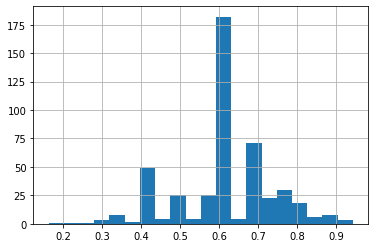

In [27]:
print('Distribution of Corrected Wilson Scores')
_ = pred_data.wilson_p.hist(bins=20)

The probability of passing a course has shifted significantly toward the center of the probability range, indicating that the courses with few people taking them are not actually likely to be 100% pass or fail. 

In [28]:
pred_data['calc_outcome'] = pred_data['success']/pred_data['trials']

Observed Fraction Passing vs Corrected Wilson Score


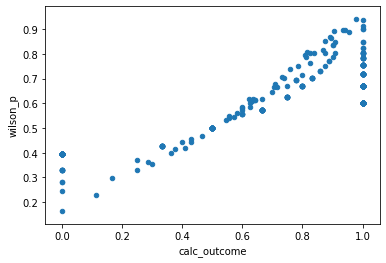

In [29]:
print('Observed Fraction Passing vs Corrected Wilson Score')
_ = pred_data.plot.scatter(x='calc_outcome', y='wilson_p')

Courses that were always passed or always failed are heavily corrected based on the number of students actually taking the course. The remaining probabilities have much smaller corrections. 

The confidence intervals should also be fairly large since most classes have only been taken a couple times. This would accurately reflect the uncertainty in those estimated outcomes - let's take a look to verify that.

Distribution of CI Sizes


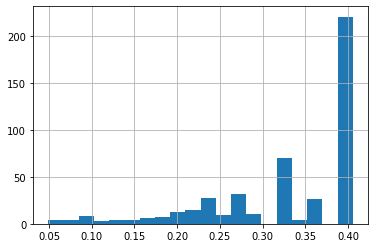

In [30]:
print('Distribution of CI Sizes')
_ = pred_data.wilson_conf.hist(bins=20)

### Model Output Interpretation

First let's see what happens for courses that were only taken once.

In [31]:
pred_data.sort_values(by='trials', ascending=True).head(10)

,success,trials,wilson_p,wilson_conf,calc_outcome
Sf Course C Name,,,,,
Intro to Counseling,1.0,1,0.603272,0.396728,1.0
Intro to Comp Data Processing,1.0,1,0.603272,0.396728,1.0
Intro to Criminal Justice,1.0,1,0.603272,0.396728,1.0
Introduction to Algebra,1.0,1,0.603272,0.396728,1.0
Introduction to Biology & Biology Lab,1.0,1,0.603272,0.396728,1.0
Introduction to Biology + Lab,0.0,1,0.396728,0.396728,0.0
Introduction to Business,0.0,1,0.396728,0.396728,0.0
Introduction to Crime and Deviance,1.0,1,0.603272,0.396728,1.0
Introduction to Environmental Science,1.0,1,0.603272,0.396728,1.0


In these cases, the probability estimate is closer to 0.5, and will shift from a discrete 0,1 to ~0.6 or ~0.4, with very large confidence intervals. This reflects the uncertainty the model should have in the estimated probability for situations with very few observations. 

Now let's investigate what happens when a class was taken many times.

In [32]:
pred_data.sort_values(by='trials', ascending=True).tail(10)

,success,trials,wilson_p,wilson_conf,calc_outcome
Sf Course C Name,,,,,
Intermediate English for Hospitality Employees,43.0,48,0.866501,0.088178,0.895833
Leadership Skills for Professionals 101,39.0,48,0.789343,0.108744,0.812500
Leadership Skills for Professionals 102,38.0,50,0.741449,0.115578,0.760000
Student Success Skills for Online Learning,50.0,56,0.867637,0.082324,0.892857
Foundations for Professional S,56.0,64,0.853765,0.081513,0.875000
Penn Foster High School,56.0,68,0.806229,0.089836,0.823529
Applying Leadership Principles,53.0,85,0.618188,0.100891,0.623529
Leadership Skills for Professionals,96.0,119,0.797131,0.070485,0.806723
Management Training Program - 16 Week,125.0,138,0.894807,0.049313,0.905797


In the 10 most-frequently taken courses, we have much more data to estimate a probability outcome, and the estimated probability is much closer to the calculation based simply on observed outcomes. The size of the confidence intervals has also dropped significantly to reflect lower variation in the likely estimated probabilities due to the presence of more observations.

## Creation of the Final 'Model' Function

Now that there is a way to estimate the probability of a course being passed, we can wrap in some behavior to handle courses we've never seen before. In the event a course has no outcomes in the data set, we can simply back off to the entire data set, with the huge, and probably unreasonable, assumption that all courses have the same probability of being passed.  However, we have to start somewhere with probabilities for passing a course we haven't seen before, and that is probably the best starting point. 

In [33]:
def get_course_probability(times_taken=None, times_passed=None):
    '''
    Function to get probability of a course being passed based on simple bernoulli trial outcomes
    with Wilson score interval
    
    inputs: times_taken: (int) Number of times the course was taken
    inputs: n_success: (int) The number of times a passing grade was achieved for the course
    
    returns: (p, conf) (tuple, floats)  The corrected probability estimate and CI range for the Wilson interval
    '''

    # In the event a course was not taken back off to data for all courses 
    if times_taken is None or times_passed is None:
        return wilson_score_interval(n_trials=2736, n_success=2142, z=1.96)
    else:
        return wilson_score_interval(n_trials=times_taken, n_success=times_passed, z=1.96)

Test the function with no inputs (a course that has never been taken):

In [34]:
get_course_probability()

(0.7824980831008623, 0.015442709983530385)

We get an estimated probability that is very close to the fraction of successful outcomes in the data set.  The confidence is likely too high for this specific case, and it should be refined further to reflex the large degree of uncertainty. 

And when a course has been taken:

In [35]:
get_course_probability(times_taken=184, times_passed=150)

(0.8087707941158934, 0.05587752255231372)

# Conclusions

How likely a course is, at a high level, going to be based on two things:
  1. The difficulty of the course
  2. The abilities of the student
  
In this data set, there is not much information that allows us to estimate the capabilities of the students. For example, outcomes per student are generally limited to one course, and very few students have taken more than 2-3 courses.

Similarly, the overwhelming majority of courses have only been taken 1 time. Due to these features in the data, I've decided to keep the model fairly simple and use Wilson score intervals on the Bernoulli outcomes of students taking each course. The score intervals have the nice property of correcting probabilities in the event few trials have been observed, and the confidence intervals will reflect the uncertainty in the probabilty estimates based on so few observed outcomes. 

In the future, additional information would be incredibly beneficial to modeling, including:
  * More information on the student's past achievement (GPA, ACT scores, etc)
  * Information on the difficulty of the course (past outcomes for students in the course) 
  * Student's additional course load at any time (more courses may equate to more likelihood of failure)